<a href="https://colab.research.google.com/github/umamahabbasi24/ML-internship-second-phase-notebooks/blob/main/End_to_End_Telco_Churn_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: End‑to‑End ML Pipeline with **Scikit‑learn Pipeline API**  
**Dataset:** Telco Customer Churn


## Objective
Build a **reusable and production‑ready** machine learning pipeline for predicting customer churn.

### What you'll practice
- Pipeline & ColumnTransformer for **preprocessing** (imputation, scaling, encoding)
- Model training with **Logistic Regression** and **Random Forest**
- **GridSearchCV** for hyperparameter tuning (multi‑metric scoring)
- **Exporting** and **reloading** the trained pipeline with `joblib`

## 1. Environment Setup

In [ ]:
#@title Install/upgrade core packages (safe to rerun)
# Install only what we need with Colab-friendly versions
# Core dependencies for ML pipeline
%pip install -q --no-deps scikit-learn==1.6.0 pandas==2.2.2 numpy==1.26.4 matplotlib seaborn joblib
print("✅ Dependencies ready (ignoring irrelevant conflicts).")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 26.6 MB/s eta 0:00:00
✅ Dependencies ready (ignoring irrelevant conflicts).


## 2. Imports & Global Settings

In [ ]:
import os, io, sys, json, joblib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             RocCurveDisplay, ConfusionMatrixDisplay)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Imports complete.")

✅ Imports complete.


## 3. Data: Load the **Telco Customer Churn** dataset

This cell will try several known public URLs. If all fail, it falls back to a file uploader.
Expected filename if uploading manually: `Telco-Customer-Churn.csv`

In [ ]:
from pathlib import Path
from typing import Optional

POSSIBLE_URLS = [
    # A few widely mirrored public copies of the IBM Telco Churn dataset.
    # If one stops working, the code will try the next.
    "https://raw.githubusercontent.com/plotly/datasets/master/telco-customer-churn.csv",
    "https://raw.githubusercontent.com/ybifoundation/Dataset/main/TelcoCustomerChurn.csv",
    "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/WA_Fn-UseC_-Telco-Customer-Churn.csv",
]

DATA_PATH = Path("Telco-Customer-Churn.csv")

def try_load_data() -> Optional[pd.DataFrame]:
    # 1) local file
    if DATA_PATH.exists():
        try:
            df = pd.read_csv(DATA_PATH)
            return df
        except Exception as e:
            print("Local read failed:", e)
    # 2) attempt URLs
    import urllib.request
    for url in POSSIBLE_URLS:
        try:
            print("Attempting:", url)
            df = pd.read_csv(url)
            # Normalize column names a bit (some mirrors differ slightly)
            df.columns = [c.strip().replace(" ", "_") for c in df.columns]
            return df
        except Exception as e:
            print("  → failed:", e)
    return None

df = try_load_data()

if df is None:
    print("\nCould not fetch via URL. Please upload the CSV manually.")
    try:
        from google.colab import files  # type: ignore
        uploaded = files.upload()
        fname = next(iter(uploaded))
        df = pd.read_csv(io.BytesIO(uploaded[fname]))
        df.columns = [c.strip().replace(" ", "_") for c in df.columns]
    except Exception as e:
        raise SystemExit("❌ Data load failed. Please re-run this cell and upload the CSV.") from e

print("✅ Loaded shape:", df.shape)
display(df.head())

Attempting: https://raw.githubusercontent.com/plotly/datasets/master/telco-customer-churn.csv
  → failed: HTTP Error 404: Not Found
Attempting: https://raw.githubusercontent.com/ybifoundation/Dataset/main/TelcoCustomerChurn.csv
  → failed: HTTP Error 404: Not Found
Attempting: https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/WA_Fn-UseC_-Telco-Customer-Churn.csv
  → failed: HTTP Error 404: Not Found

Could not fetch via URL. Please upload the CSV manually.


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
✅ Loaded shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 4. Quick Data Audit

Using target column: Churn
Dropped ID column: customerID


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
185,Female,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,24.80,24.80,Yes
2715,Male,0,No,No,41,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer (automatic),25.25,996.45,No
3825,Female,0,Yes,Yes,52,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.35,1031.70,No
1807,Female,0,No,No,1,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Electronic check,76.35,76.35,Yes
132,Male,0,No,No,67,Yes,No,DSL,No,No,No,Yes,No,No,Two year,No,Bank transfer (automatic),50.55,3260.10,No



Data types:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

Missing values per column:


,missing
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0



Target distribution:


,percent
Churn,
No,73.46
Yes,26.54


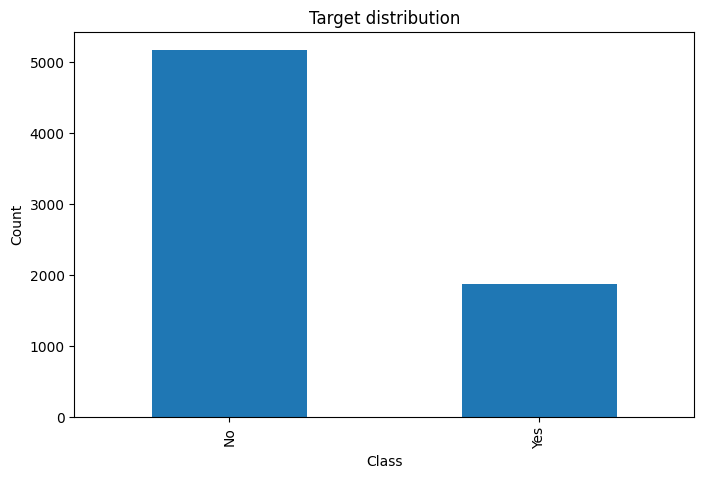

In [ ]:
# Standardize target column name across mirrors
TARGET_CANDIDATES = ["Churn", "churn", "customer_churn", "Churn?"]
target = None
for name in TARGET_CANDIDATES:
    if name in df.columns:
        target = name
        break
if target is None:
    # Common mirror uses 'Churn' or 'customerID' etc.
    # Try to infer binary column with 'Yes/No'
    yesno_cols = [c for c in df.columns if set(df[c].astype(str).unique()) >= {"Yes","No"}]
    target = "Churn" if "Churn" in yesno_cols else (yesno_cols[0] if yesno_cols else None)

if target is None:
    raise ValueError("Could not identify the churn target column automatically. Please rename your target to 'Churn'.")
print("Using target column:", target)

# Drop obvious ID column if present
for id_like in ["customerID", "CustomerID", "customer_Id", "customer_ID"]:
    if id_like in df.columns:
        df = df.drop(columns=[id_like])
        print("Dropped ID column:", id_like)

# Convert "TotalCharges" to numeric if present & dirty
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Basic info
display(df.sample(5, random_state=RANDOM_STATE))
print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
display(df.isna().sum().to_frame("missing"))

# Target distribution
print("\nTarget distribution:")
display(df[target].value_counts(normalize=True).mul(100).round(2).to_frame("percent"))

# Simple bar chart for target
ax = df[target].value_counts().plot(kind="bar")
ax.set_title("Target distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

## 5. Train / Test Split

In [ ]:
X = df.drop(columns=[target])
y = df[target].astype(str).str.strip().str.title()  # normalize "Yes"/"No" capitalization
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, " Test:", X_test.shape)

Train: (5634, 19)  Test: (1409, 19)


## 6. Preprocessing with **ColumnTransformer**

In [ ]:
# Automatically pick numeric & categorical columns
numeric_features = selector(dtype_include=np.number)(X_train)
categorical_features = selector(dtype_exclude=np.number)(X_train)

print("Numeric columns:", len(numeric_features))
print("Categorical columns:", len(categorical_features))

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_precess := numeric_preprocess, numeric_features),
        ("cat", categorical_precess := categorical_preprocess, categorical_features),
    ],
    remainder="drop",
    n_jobs=None  # ColumnTransformer doesn't use n_jobs
)

print("✅ Preprocessor ready.")

Numeric columns: 4
Categorical columns: 15
✅ Preprocessor ready.


## 7. Models & Hyperparameter Search Space

In [ ]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    solver="saga",
    n_jobs=None,
    random_state=RANDOM_STATE
)

rf_clf = RandomForestClassifier(
    n_estimators=400,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", log_reg)  # placeholder, will be overridden by param grid
])

# Two separate grids so we can switch estimators cleanly
param_grid = [
    {
        "clf": [log_reg],
        "clf__C": [0.1, 0.5, 1.0, 2.0],
        "clf__penalty": ["l1", "l2"],
    },
    {
        "clf": [rf_clf],
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 5],
        "clf__min_samples_leaf": [1, 2],
    }
]

scoring = {
    "roc_auc": "roc_auc",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall",
    "accuracy": "accuracy",
}

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("✅ GridSearchCV prepared.")

✅ GridSearchCV prepared.


## 8. Train & Tune

In [ ]:
%%time
search.fit(X_train, y_train)
print("\n✅ Best estimator:", search.best_estimator_)
print("Best params:", search.best_params_)
print("Best CV ROC-AUC: {:.4f}".format(search.best_score_))

Fitting 5 folds for each of 32 candidates, totalling 160 fits

✅ Best estimator: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                          

## 9. Evaluation on Test Set


Classification report:
              precision    recall  f1-score   support

          No       0.89      0.78      0.83      1035
         Yes       0.55      0.72      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409

Test ROC-AUC: 0.8403


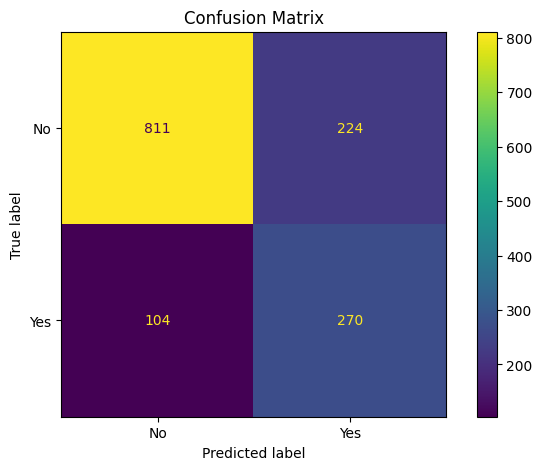

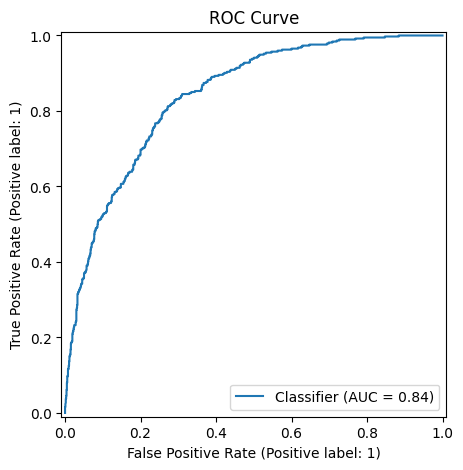

In [ ]:
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Use predict_proba if available for ROC-AUC
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:, 1]
else:
    # For safety fallback, map decision_function to a 0-1 range
    if hasattr(best_model, "decision_function"):
        from sklearn.preprocessing import MinMaxScaler
        scores = best_model.decision_function(X_test).reshape(-1,1)
        y_prob = MinMaxScaler().fit_transform(scores).ravel()
    else:
        y_prob = (y_pred == y_pred.max()).astype(float)  # degenerate fallback

print("\nClassification report:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test.map({"No":0, "Yes":1}), y_prob)
print("Test ROC-AUC: {:.4f}".format(auc))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=["No","Yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No","Yes"])
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test.map({"No":0,"Yes":1}), y_prob)
plt.title("ROC Curve")
plt.show()

## 10. Export the **complete pipeline** with `joblib`

In [ ]:
MODEL_PATH = "telco_churn_pipeline.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"✅ Saved pipeline to: {MODEL_PATH} ({os.path.getsize(MODEL_PATH)/1024:.1f} KB)")

✅ Saved pipeline to: telco_churn_pipeline.joblib (15288.0 KB)


## 11. Reload & Inference Demo

In [ ]:
loaded = joblib.load(MODEL_PATH)
print("✅ Reloaded type:", type(loaded))

sample = X_test.sample(3, random_state=RANDOM_STATE)
print("Sample rows:")
display(sample)

pred = loaded.predict(sample)
proba = loaded.predict_proba(sample)[:, 1] if hasattr(loaded, "predict_proba") else None

print("\nPredictions:", pred.tolist())
if proba is not None:
    print("Probabilities:", [round(p, 4) for p in proba.tolist()])

✅ Reloaded type: <class 'sklearn.pipeline.Pipeline'>
Sample rows:


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5902,Female,0,Yes,No,9,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,No,Mailed check,50.85,466.60
5415,Female,0,No,No,18,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,50.30,913.30
2874,Female,0,Yes,No,64,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),19.45,1225.65



Predictions: ['No', 'Yes', 'No']
Probabilities: [0.3189, 0.5204, 0.0039]


## 12. (Optional) Feature Importances

In [ ]:
from sklearn.inspection import permutation_importance

clf = loaded.named_steps["clf"]
if isinstance(clf, RandomForestClassifier):
    # Extract feature names from the pipeline to align with RF input
    onehot = loaded.named_steps["preprocess"].named_transformers_["cat"].named_steps["onehot"]
    cat_names = onehot.get_feature_names_out(loaded.named_steps["preprocess"].transformers_[1][2])
    num_names = loaded.named_steps["preprocess"].transformers_[0][2]
    all_names = np.r_[num_names, cat_names]

    importances = pd.Series(clf.feature_importances_, index=all_names).sort_values(ascending=False)
    display(importances.head(20).to_frame("importance"))
else:
    print("Feature importances are shown only for RandomForestClassifier.")

,importance
tenure,0.124423
Contract_Month-to-month,0.122062
TotalCharges,0.103869
MonthlyCharges,0.072033
Contract_Two year,0.060994
OnlineSecurity_No,0.060568
InternetService_Fiber optic,0.048515
TechSupport_No,0.046317
PaymentMethod_Electronic check,0.035911
OnlineBackup_No,0.018806


## 13. Production‑readiness Notes

- **Single pipeline object** encapsulates preprocessing + model ⇒ deploy one artifact.
- Use `Pipeline` caching with `memory=joblib.Memory("./cache")` for expensive transforms.
- Monitor **data drift** (categorical levels, numeric ranges). Refit the encoder if categories change.
- Track versions of `scikit-learn`, dataset schema, and **random seeds** for reproducibility.
- For highly imbalanced data, consider **threshold tuning**, **calibration**, or `class_weight`/SMOTE